### Introduction
The provided Python code facilitates the development of a movie recommendation system using Surprise, a Python scikit for building and analyzing recommender systems. The system is designed to predict user ratings for movies based on collaborative filtering techniques.

### Data Loading and Preprocessing
The code begins by loading three essential datasets: **movies.csv**, **ratings.csv**, and **links.csv**, containing information about movies, user ratings, and movie links, respectively. These datasets are crucial for training and testing the recommendation system.

### Model Training - Singular Value Decomposition (SVD)
The primary recommendation model used is Singular Value Decomposition (SVD), implemented through Surprise. The code trains the SVD model using cross-validation and hyperparameter tuning to optimize performance.

### Evaluation and Analysis - SVD Model
Once trained, the SVD model is evaluated using root mean square error (RMSE) and mean absolute error (MAE) metrics. Additionally, the code visualizes the distribution of prediction errors and the estimated ratings using histograms and box plots.

### Model Training - Co-Clustering
Another recommendation model explored is Co-Clustering, an algorithm based on co-clustering of users and items. Similar to SVD, hyperparameter tuning and cross-validation are employed to optimize the Co-Clustering model.

### Evaluation and Analysis - Co-Clustering Model
Similarly, the Co-Clustering model is evaluated using RMSE and MAE metrics, with prediction error distribution and estimated rating visualization provided for analysis.

### Generating Top-N Recommendations
The code includes functionality to generate top-N movie recommendations for a specific user. It employs the trained Co-Clustering model to predict ratings for all movies not rated by the user and recommends the top-N movies with the highest predicted ratings.

### Conclusion and Results Storage
In conclusion, this code demonstrates the development of a movie recommendation system using collaborative filtering techniques. It evaluates and compares the performance of SVD and Co-Clustering models and provides functionality for generating personalized movie recommendations.


In [1]:
import pandas as pd
import joblib

In [2]:
from surprise import Dataset, SVD, Reader, accuracy
from surprise.model_selection import cross_validate, train_test_split
from surprise.model_selection import GridSearchCV


In [3]:
movies = pd.read_csv("movies.csv")
ratings = pd.read_csv("ratings.csv")
links = pd.read_csv("links.csv")

In [4]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[["userId", "movieId", "rating"]], reader)

In [5]:
algo = SVD()

In [6]:
trainset, testset = train_test_split(data, test_size=0.2, random_state=142)

In [7]:
param_grid = {"n_epochs": [5, 10, 20, 25], "lr_all": [0.002, 0.005, 0.007], "reg_all": [0.4, 0.6, 0.8]}

In [8]:
%%time
gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=3)

gs.fit(data)

CPU times: user 39.6 s, sys: 291 ms, total: 39.9 s
Wall time: 40.5 s


In [9]:
print(gs.best_score["rmse"])

# combination of parameters that gave the best RMSE score
print(gs.best_params["rmse"])

0.883135873421962
{'n_epochs': 25, 'lr_all': 0.007, 'reg_all': 0.4}


In [10]:
%%time
algo = gs.best_estimator["rmse"]
algo.fit(data.build_full_trainset())

CPU times: user 537 ms, sys: 2.84 ms, total: 540 ms
Wall time: 541 ms


In [11]:
predictions = algo.test(testset)

In [12]:
predictions_df = pd.DataFrame(predictions, columns=["raw_user_id", "raw_item_id", "actual_user_rating", "estimated_user_rating", "details"])

In [13]:
accuracy.fcp(predictions)

FCP:  0.7391


0.7391100941406844

In [14]:
predictions_df["difference"] = predictions_df["actual_user_rating"] - predictions_df["estimated_user_rating"]

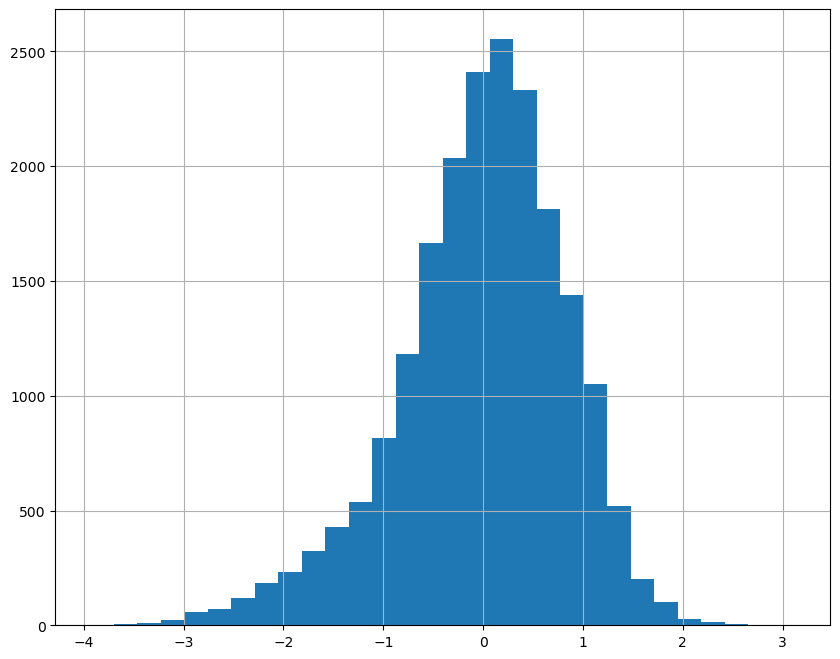

In [15]:
predictions_df["difference"].hist(bins=30,
                                  figsize=(10, 8));

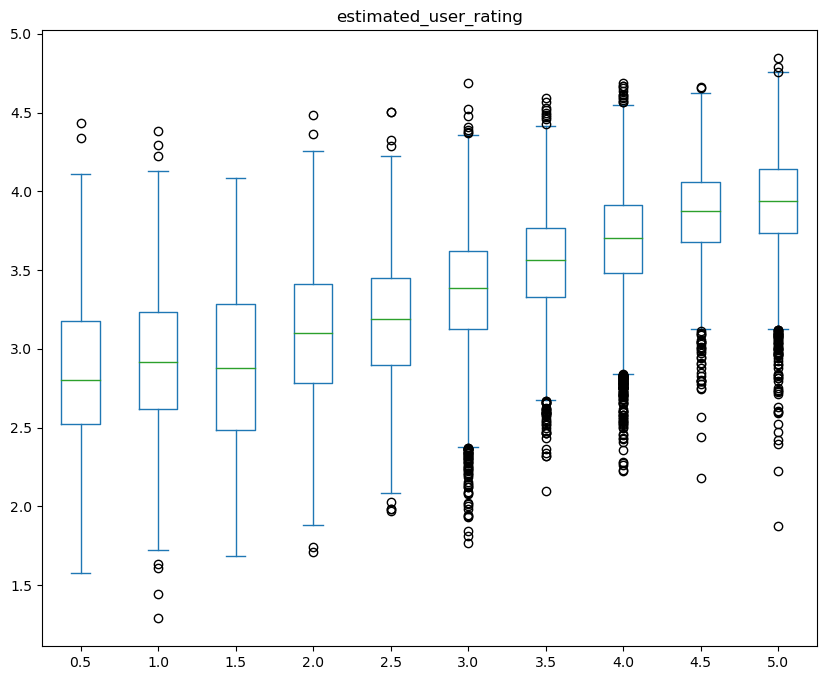

In [16]:
predictions_df.plot(kind='box',
                    column='estimated_user_rating',
                    by='actual_user_rating',
                    figsize=(10, 8));

In [17]:
from surprise.prediction_algorithms.co_clustering import CoClustering

In [18]:
param_grid2 = {"n_epochs": [5, 10, 20, 25], "n_cltr_u": [3, 5, 7], "n_cltr_i": [3, 5, 7]}

In [19]:
%%time
CoC = GridSearchCV(CoClustering, param_grid2, measures=["rmse", "mae"], cv=3)

CoC.fit(data)

CPU times: user 1min 4s, sys: 280 ms, total: 1min 4s
Wall time: 1min 5s


In [20]:
print(CoC.best_score["rmse"])

# combination of parameters that gave the best RMSE score
print(CoC.best_params["rmse"])

0.9508148711118993
{'n_epochs': 20, 'n_cltr_u': 3, 'n_cltr_i': 3}


In [21]:
%%time
coc_algo = CoC.best_estimator["rmse"]
coc_algo.fit(data.build_full_trainset())

predictions_coc = coc_algo.test(testset)

CPU times: user 789 ms, sys: 15.7 ms, total: 805 ms
Wall time: 819 ms


In [22]:
predictions_coc_df = pd.DataFrame(predictions_coc, columns=["raw_user_id", "raw_item_id", "actual_user_rating", "estimated_user_rating", "details"])

In [23]:
accuracy.fcp(predictions_coc)

FCP:  0.7469


0.7469006916772152

In [24]:
predictions_coc_df["difference"] = predictions_coc_df["actual_user_rating"] - predictions_coc_df["estimated_user_rating"]

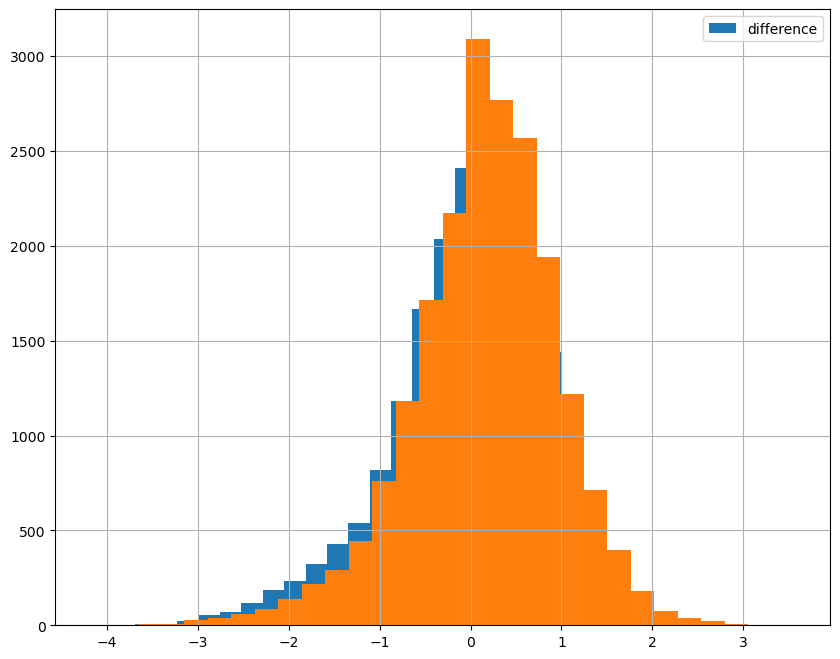

In [25]:
predictions_df["difference"].hist(bins=30,
                                  figsize=(10, 8), legend=True);
predictions_coc_df["difference"].hist(bins=30,
                                  figsize=(10, 8));

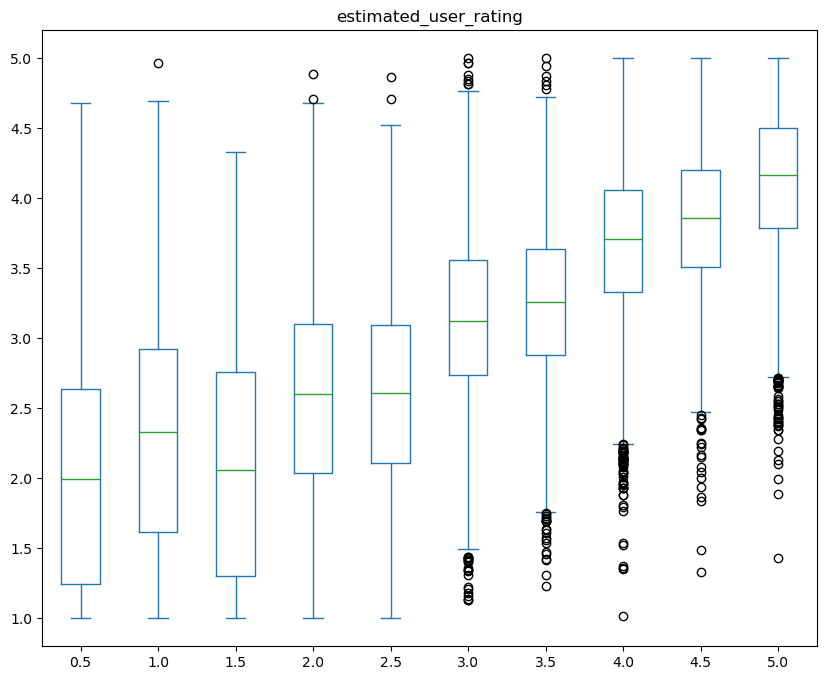

In [26]:
predictions_coc_df.plot(kind='box',
                    column='estimated_user_rating',
                    by='actual_user_rating',
                    figsize=(10, 8));

In [27]:
%%time
testset = trainset.build_anti_testset()
predictions = coc_algo.test(testset)

CPU times: user 12.8 s, sys: 4.52 s, total: 17.3 s
Wall time: 20.4 s


In [28]:
def get_top_n(testset, user_id, n):
    # Filter the testset to include only rows with the specified user_id
    filtered_testset = [row for row in testset if row[0] == user_id]

    # Make predictions on the filtered testset
    predictions = coc_algo.test(filtered_testset)

    # Create a DataFrame from the predictions and return the top n predictions based on the estimated ratings ('est')
    top_n_predictions_df = pd.DataFrame(predictions).nlargest(n, 'est')

    return top_n_predictions_df

In [29]:
top_n_df = get_top_n(testset, 41, 10)
reduced_top_n_df = top_n_df.loc[:, ["iid", "est"]].rename(columns={"iid": "movieId", "est": "estimated_rating"})
final = reduced_top_n_df.merge(movies, how="left", on="movieId")

In [30]:
pred_df = pd.DataFrame(predictions, columns=["usrId", "movieId", "r_rating", "estimated", "details"])

In [31]:
pred_df.shape

(5367242, 5)

In [32]:
users = pred_df.usrId.unique()

In [33]:
%%time
user_db = {}
for user in users:
    temp = (pred_df.loc[pred_df.usrId == user]
            .sort_values("estimated", ascending=False).head(10)["movieId"]
     .tolist())
    user_db[user] = temp    

CPU times: user 4.77 s, sys: 577 ms, total: 5.35 s
Wall time: 1.99 s


In [34]:
joblib.dump(user_db, "user_db")

['user_db']